In [1]:
from model import *
from helpers import *

In [2]:
def analyze_pO2(results):
    t = results['t']
    pO2 = results['pO2']

    final_pO2 = pO2[-1]
    SMIF_threshold = (2.1 / 1e6) / 0.2  # ppm to PAL fraction

    below = pO2 < SMIF_threshold
    dt = np.diff(t)
    dt = np.append(dt, dt[-1])  # Ensure same length
    time_below_SMIF = np.sum(dt[below])

    return final_pO2, time_below_SMIF


In [3]:
def sweep_grid(V_C_array, V_red_array, default_params, verbose=False):
    final_pO2_grid = np.full((len(V_red_array), len(V_C_array)), np.nan)
    SMIF_time_grid = np.full_like(final_pO2_grid, np.nan)

    for i, V_red in enumerate(V_red_array):
        #if verbose:
            #print(f"Running with V_red={V_red:0.2f}...")
        for j, V_C in enumerate(V_C_array):
            params = default_params.copy()
            params['V_C'] = V_C
            params['V_red'] = V_red

            if verbose:
                print(f"Running with V_C={V_C:0.2f}, V_red={V_red:0.2f}...")

            try:
                results = run_model(**params)
                final_pO2, time_below_SMIF = analyze_pO2(results)
                final_pO2_grid[i, j] = final_pO2
                SMIF_time_grid[i, j] = time_below_SMIF
            except Exception as e:
                pass
                #print(f"    Skipped due to error: {e}")

    return final_pO2_grid, SMIF_time_grid

In [4]:
V_C_values = np.linspace(6.5, 10.5, 30)
V_red_values = np.linspace(0, 0.2*10.5, 30)

default_params = {"tau": 18,"W_LIP": 9,"dt":1e4/1e6}

# Run the grid sweep
final_pO2_grid, SMIF_time_grid = sweep_grid(V_C_values, V_red_values, default_params)

/Users/cminsky/Documents/Research/Sturtian-limit-cycles/model.py:145: UserWarning: Carbon cycle out of balance by 1.33e-15
  warnings.warn(f"Carbon cycle out of balance by {np.abs(dNdt):0.2e}")
/Users/cminsky/Documents/Research/Sturtian-limit-cycles/model.py:145: UserWarning: Carbon cycle out of balance by 1.55e-15
  warnings.warn(f"Carbon cycle out of balance by {np.abs(dNdt):0.2e}")
/Users/cminsky/Documents/Research/Sturtian-limit-cycles/model.py:145: UserWarning: Carbon cycle out of balance by 1.78e-15
  warnings.warn(f"Carbon cycle out of balance by {np.abs(dNdt):0.2e}")
/Users/cminsky/Documents/Research/Sturtian-limit-cycles/model.py:145: UserWarning: Carbon cycle out of balance by 2.22e-15
  warnings.warn(f"Carbon cycle out of balance by {np.abs(dNdt):0.2e}")


In [5]:
def plot_final_pO2_contour(V_C_array, V_red_array, final_pO2_grid, cmap='PuBuGn'):
    V_C_mesh, V_red_mesh = np.meshgrid(V_C_array, V_red_array)

    fig = plt.figure(figsize=(4.18, 2.54))
    ax = fig.add_axes([0, 0, 1, 1])

    # contour lines
    labeled_levels = [0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6]
    cs = ax.contour(V_C_mesh, V_red_mesh, final_pO2_grid,
                    levels=labeled_levels, cmap=cmap, linewidths=2)
    ax.clabel(cs, inline=True, fontsize=8, colors='black',
          fmt=lambda x: f"{x:.1f} PAL")

    # grey mask
    invalid_mask = np.isnan(final_pO2_grid).astype(float)
    ax.contourf(V_C_mesh, V_red_mesh, invalid_mask,
                levels=[0.5, 1.5], colors='lightgrey')
    ax.text(6.6, 2.0,
            "Initial conditions\nnot self-consistent",
            color='k', fontsize=10, ha='left', va='top')

    # formatting
    ax.set_xlabel("Volcanic CO$_2$ [Tmol C/yr]")
    ax.set_ylabel("Volcanic reduced gases [Tmol O$_2$/yr]")
    ax.set_title("Final pO$_2$ at end of 80-Myr model run")

    return fig


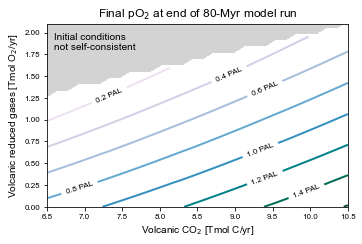

In [6]:
fig1 = plot_final_pO2_contour(V_C_values, V_red_values, final_pO2_grid)
figname="O2_volc_final.pdf"
savefig(fig1,figname,savefmt='pdf',supp_folder="supp")

In [11]:
import matplotlib.colors as mcolors

def plot_SMIF_time_contour(V_C_array, V_red_array, SMIF_time_grid, cmap='plasma'):
    V_C_mesh, V_red_mesh = np.meshgrid(V_C_array, V_red_array)

    fig = plt.figure(figsize=(4.18, 2.54))
    ax = fig.add_axes([0, 0, 1, 1])
    
    colormap = plt.get_cmap(cmap)
    norm = mcolors.Normalize(vmin=np.nanmin(SMIF_time_grid), vmax=np.nanmax(SMIF_time_grid))

    # 0 level line color
    rgba = list(colormap(norm(0.0)))
    rgba[3] = 0.4  # 40% opacity
    color_for_zero = tuple(rgba)
    
    # fill region where SMIF_time is 0
    ax.contourf(V_C_mesh, V_red_mesh, SMIF_time_grid,
                levels=[-1e-6, 1e-6],
                colors=[color_for_zero],
                zorder=0)
    ax.text(10.3, 0.1,
            "pO$_2$ never below\nS-MIF threshold",
            color='k', fontsize=10, ha='right', va='bottom')

    # contour lines
    labeled_levels = [0,0.3,2]
    cs = ax.contour(V_C_mesh, V_red_mesh, SMIF_time_grid,
                    levels=labeled_levels, cmap=cmap, zorder=2)
    ax.clabel(cs, inline=True, fontsize=8, colors='black',
          fmt=lambda x: f"{x:.1f} Myr")

    # grey mask
    invalid_mask = np.isnan(final_pO2_grid).astype(float)
    ax.contourf(V_C_mesh, V_red_mesh, invalid_mask,
                levels=[0.5, 1.5], colors='lightgrey')
    ax.text(6.6, 2.0,
            "Initial conditions\nnot self-consistent",
            color='k', fontsize=10, ha='left', va='top')

    # formatting
    ax.set_xlabel("Volcanic CO$_2$ [Tmol C/yr]")
    ax.set_ylabel("Volcanic reduced gases [Tmol O$_2$/yr]")
    ax.set_title("Total time pO$_2$ is below S-MIF threshold")

    return fig


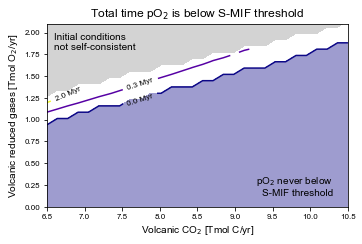

In [12]:
fig2 = plot_SMIF_time_contour(V_C_values, V_red_values, SMIF_time_grid)
figname="O2_volc_SMIF.pdf"
savefig(fig2,figname,savefmt='pdf',supp_folder="supp")